# Hotel Review Sentiment Analysis

- [1. Imports and Constants](#1.-Imports-and-Constants)
- [2. Exploratory Analysis and Data Cleaning](#2.-Exploratory-Analysis-and-Data-Cleaning)
    - [2.1 Dataset 1](#2.1-Dataset-1)
    - [2.2 Dataset 2](#2.2-Dataset-2)
    - [2.3 Dataset 3](#2.3-Dataset-3)
    - [2.4 Combining the Three Datasets](#2.4-Combining-the-Three-Datasets)
- [3. Translation of non-English Reviews](#3.-Translation-of-non-English-reviews)
- [4. Sentiment Analysis](#4.-Sentiment-Analysis)
    - [4.1 Pros and Cons of Various Approaches](#4.1-Pros-and-Cons-of-Various-Approaches)
    - [4.2 Approach 1: Google Natural Language API](#4.2-Approach-1:-Google-Natural-Language-API)
        - [4.2.1 Getting Google Sentiment Scores](#4.2.1-Getting-Google-Sentiment-Scores)
        - [4.2.2 Scoring Each Review in the Dataset](#4.2.2-Scoring-Each-Review-in-the-Dataset)
        - [4.2.3 Evaluating Resultant Sentiment Scores](#4.2.3-Evaluating-Resultant-Sentiment-Scores)
        - [4.2.4 Calculating Difference between Sentiment Score and Rating](#4.2.4-Calculating-Difference-between-Sentiment-Score-and-Rating)
    - [4.3 Approach 2: SentiWordNet Average Sentiment Scores](#4.3-Approach-2:-SentiWordNet-Average-Sentiment-Scores)
        - [4.3.1 Defining the Scoring Function](#4.3.1-Defining-the-Scoring-Function)
        - [4.3.2 Scoring Each Review in the Dataset](#4.3.2-Scoring-Each-Review-in-the-Dataset)
        - [4.3.3 Evaluating Resultant Sentiment Scores](#4.3.3-Evaluating-Resultant-Sentiment-Scores)
        - [4.3.4 Calculating Difference between Sentiment Score and Rating](#4.3.4-Calculating-Difference-between-Sentiment-Score-and-Rating)
    - [4.4 Approach 3: Naive Bayes Classifier Sentiment Scores](#4.4-Approach-3:-Naive-Bayes-Classifier-Sentiment-Scores)
        - [4.4.1 Text Preprocessing](#4.4.1-Text-Preprocessing)
        - [4.4.2 Train-Test Split](#4.4.2-Train-Test-Split)
        - [4.4.3 Fitting and Evaluating the Model](#4.4.3-Fitting-and-Evaluating-the-Model)
        - [4.4.4 Scoring Each Review in the Dataset](#4.4.4-Scoring-Each-Text-in-the-Dataset)
        - [4.4.5 Evaluating Resultant Sentiment Scores](#4.4.5-Evaluating-Resultant-Sentiment-Scores)
        - [4.4.6 Calculating Difference between Sentiment Score and Rating](#4.4.6-Calculating-Difference-between-Sentiment-Score-and-Rating)
    - [4.5 Approach 4: LSTM Neural Network Classifier Sentiment Scores](#4.5-Approach-4:-LSTM-Neural-Network-Classifier-Sentiment-Scores)
        - [4.5.1 Text Preprocessing](#4.5.1-Text-Preprocessing)
        - [4.5.2 Train-Test Split](#4.5.2-Train-Test-Split)
        - [4.5.3 Fitting and Evaluating the Model](#4.5.3-Fitting-and-Evaluating-the-Model)
        - [4.5.4 Scoring Each Review in the Dataset](#4.5.4-Scoring-each-Review-in-the-Dataset)
        - [4.5.5 Evaluating Resultant Sentiment Scores](#4.5.5-Evaluating-Resultant-Sentiment-Scores)
        - [4.5.6 Calculating Difference between Sentiment Score and Rating](#4.5.6-Calculating-Difference-between-Sentiment-Score-and-Rating)
- [5. Conclusion](#5.-Conclusion) 

## 1. Imports and Constants

In [954]:
from enum import Enum
from string import printable
import time
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#Google cloud API imports
from google.cloud import translate_v2 as translate
from google.cloud.exceptions import Forbidden
from google.cloud.exceptions import BadRequest

from google.cloud import language
from google.cloud.language import enums as gc_enums
from google.cloud.language import types as gc_types

import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from unidecode import unidecode
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from keras.preprocessing.text import Tokenizer
import keras.preprocessing.sequence

import tensorflow as tf

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
tqdm.pandas() #allows progress bar support for pandas mapping functions
from keras_tqdm import TQDMNotebookCallback #tqdm progress bars for keras 

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
%env GOOGLE_APPLICATION_CREDENTIALS translationKeys.json

env: GOOGLE_APPLICATION_CREDENTIALS=translationKeys.json


In [342]:
#The dataset provided consists of three csv files, each with slightly different schema
DATASET_1 = "dataset/7282_1.csv"
DATASET_2 = "dataset/Datafiniti_Hotel_Reviews.csv"
DATASET_3 = "dataset/Datafiniti_Hotel_Reviews_Jun19.csv"

TEST_PROPORTION = 0.25

USE_TRANSLATOR = True

TRANSLATOR_OPTIONS = Enum("OPTIONS", "TRANSLATE REMOVE THRESHOLD")
TRANSLATOR_FUNCTIONALITY = TRANSLATOR_OPTIONS.TRANSLATE #options are "translate", which translates non-english text to english, and 
                                        # "remove", which drops records with non-english text from the training set
TRANSLATOR_THRESHOLD=0.05

## 2. Exploratory Analysis and Data Cleaning

In [69]:
#first run at cleaning the dataset - more specific data cleaning will be done as I learn more about the
# dataset structure
def clean_df(frame):
    
    #because I was having trouble with non-latin characters in strings (Japanese charsets, etc.) this project
    # encodes all strings as utf-8 codepoints and decodes to strings as necessary. This feels sub-optimal, but
    # as it works, I will keep it like this at this stage
    frame["reviews.text"] = frame["reviews.text"].str.encode("utf-8")

    if ("translated_text" in frame.columns):
        frame["translated_text"] = frame["translated_text"].str.encode("utf-8")
    
    #keep only ratings that have a review attached (that is, not Na or empty or only whitespace)
    frame = frame[~frame["reviews.text"].isnull()] 
    frame = frame[frame["reviews.text"] != ""]
    frame = frame[~frame["reviews.text"].str.isspace()]
    
    frame = frame.reset_index(drop=True)
    
    return frame

def load_dataset(filename):
    frame = pd.read_csv(filename)
    frame = clean_df(frame)
    return frame

def save_dataset(frame, filename):
    
    frame = frame.copy()
    
    frame["reviews.text"] = frame["reviews.text"].map(lambda x: x.decode("utf-8"))
    
    if ("translated_text" in frame.columns):
        frame["translated_text"] = frame["translated_text"].map(lambda x: x.decode("utf-8"))
        
    frame.to_csv(filename, encoding="utf-8")
    

### 2.1 Dataset 1

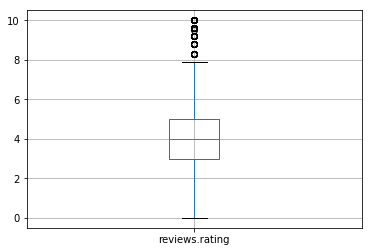

In [4]:
df_1 = load_dataset(DATASET_1)
#print(df)
#df_1.head()

df_1.boxplot(column="reviews.rating")


In [5]:
print(df_1["reviews.rating"].value_counts())

5.0     12664
4.0      9747
3.0      5705
1.0      3065
2.0      2978
0.0       337
10.0      101
9.6        53
9.2        49
4.3        26
4.8        25
8.3        25
7.9        24
7.5        24
8.8        24
4.2        22
3.4        17
4.1        14
6.3        14
7.1        13
4.5        13
6.7        12
5.4         9
4.6         7
3.1         7
5.8         6
4.4         6
3.3         6
4.7         6
4.9         6
2.4         4
2.5         3
3.8         3
3.7         2
3.2         2
3.9         2
2.8         1
1.3         1
9.5         1
1.5         1
6.0         1
2.9         1
7.0         1
Name: reviews.rating, dtype: int64


In [6]:
print(df_1[df_1["reviews.rating"] > 5].head())


              address categories      city country  latitude  longitude  \
4448  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4449  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4450  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4451  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4452  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   

                         name postalCode province          reviews.date  \
4448  Hyatt Regency Kathmandu      44601       OH  2015-08-11T00:00:00Z   
4449  Hyatt Regency Kathmandu      44601       OH  2016-01-12T00:00:00Z   
4450  Hyatt Regency Kathmandu      44601       OH  2015-06-22T00:00:00Z   
4451  Hyatt Regency Kathmandu      44601       OH  2016-05-17T00:00:00Z   
4452  Hyatt Regency Kathmandu      44601       OH  2016-07-09T00:00:00Z   

         reviews.dateAdded  reviews.doRecommend  reviews.id  reviews.rating  \
4448  2016-11-11T23

In [7]:
print(df_1[df_1["reviews.rating"] == 0].head())

                                      address  \
57                      2113 Sapp Brothers Dr   
58                             2860 Grand Ave   
59  142 Park Place Us 181 Business At Park Pl   
79                      435 E Avenida Olancha   
97                              316 N Main St   

                                          categories          city country  \
57                             Lodging,Hotels,Motels      Percival      US   
58                                Hotels,Restaurants    Los Olivos      US   
59                                            Hotels        Kenedy      US   
79                                      Hotels,Hotel  Palm Springs      US   
97  Motels,Hotels,Restaurants,Bed & Breakfast & Inns       Neihart      US   

     latitude   longitude                     name postalCode province  \
57  40.689730  -95.788826  Americas Best Value Inn      51648       IA   
58  34.664684 -120.115036               Intermezzo      93441       CA   
59  28.793795 

From the unique values in DATASET_1, it seems that, while most of the reviews are rated on an integer scale between 1 and 5, at least some of the reviews are rated from 1.0-10.0. These reviews should be removed or re-scaled (I have chosen to remove them, as there are comparatively very few of them and there may be differences between what a user means by choosing two equivalent ratings on the two scales - ie. a 8/10 rating may have different connotations on average to a 4/5 rating.)

Note: It is impossible to tell which of the remaining reviews are actually rated out of 10 rather than 5 - however, assuming the distribution of ratings out of 10 is similar to the distribution for ratings out of 5, there should be very few of these and their effect on any statistical analysis should be minor.

Additionally, a quick glance at the 0 ratings suggests that these are not real reviews, but some artifact of the scraping process, and so should be removed as well.

In [8]:
df_1 = df_1[df_1["reviews.rating"].isin([1.0,2.0,3.0,4.0,5.0])]

print(df_1["reviews.rating"].value_counts())

5.0    12664
4.0     9747
3.0     5705
1.0     3065
2.0     2978
Name: reviews.rating, dtype: int64


count    34159.000000
mean       256.185544
std        219.689435
min          1.000000
25%        103.000000
50%        227.000000
75%        330.000000
max       3827.000000
Name: reviews.length, dtype: float64


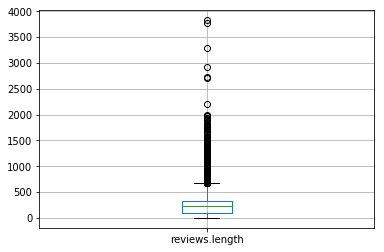

In [9]:
df_1["reviews.length"] = df_1["reviews.text"].str.len()

print(df_1["reviews.length"].describe())

df_1.boxplot(column="reviews.length")


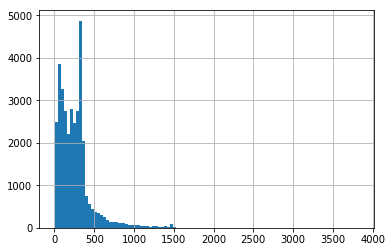

In [10]:
df_1["reviews.length"].hist(bins=100)

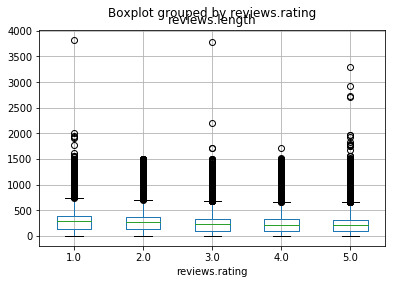

In [11]:
df_1.boxplot(column="reviews.length", by="reviews.rating")

Beacuse there is a large drop off in the number of reviews at around 450 characters, I have decided to remove all reviews longer than that, as their outlier status may negatively affect their usefulness in creating accurate sentiment analysis methodologies

To remove reviews that are too small to be of use in determining sentiment, I have decided to use the 25th percentile length value (~100) as the minimum cutoff point.

In [12]:
LOWER_BOUND = 100
UPPER_BOUND = 450

orig_size = df_1["reviews.text"].count()

df_1 = df_1[df_1["reviews.length"].between(LOWER_BOUND, UPPER_BOUND)]


new_size = df_1["reviews.text"].count()

print("Number of records in pruned dataset: {}", new_size)
print("Percentage of records kept: %{}", (new_size/orig_size * 100))


Number of records in pruned dataset: {} 22395
Percentage of records kept: %{} 65.56105272402588


With around 65% of records kept from the dataset, I feel that these upper and lower bounds for length strike a good balance between removing outliers and keeping a large enough corpus to train any sentiment analysis models with.

### 2.2 Dataset 2

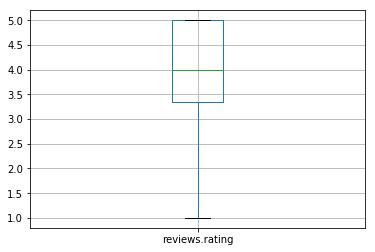

In [13]:
df_2 = load_dataset(DATASET_2)
df_2.head()

df_2.boxplot(column="reviews.rating")

In [14]:
print(df_2["reviews.rating"].value_counts())

5.00    4384
4.00    2397
3.00    1186
1.00     572
2.00     561
4.80     162
4.60     155
4.40     102
3.75      91
4.15      78
3.95      52
3.55      50
3.35      40
3.15      37
2.90      34
2.70      23
2.50      19
2.30      12
2.10      11
1.65       8
1.45       6
4.50       4
1.90       4
3.25       2
3.50       2
1.25       2
4.25       2
2.75       1
4.75       1
3.45       1
Name: reviews.rating, dtype: int64


For DATASET_2, all reviews are rated on the 1-5 scale, but a small minority are non-integer ratings. Here, it makes sense to round these ratings to the nearest integer

In [15]:
df_2["reviews.rating"] = df_2["reviews.rating"].round()

print(df_2["reviews.rating"].value_counts())

5.0    4702
4.0    2778
3.0    1324
2.0     615
1.0     580
Name: reviews.rating, dtype: int64


count    9999.000000
mean      324.666367
std       295.447557
min         1.000000
25%       201.000000
50%       298.000000
75%       344.000000
max      5939.000000
Name: reviews.length, dtype: float64


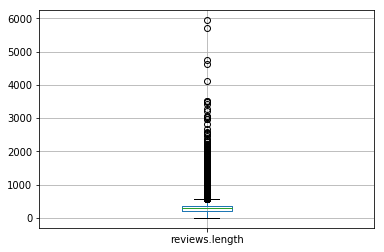

In [16]:
df_2["reviews.length"] = df_2["reviews.text"].str.len()

print(df_2["reviews.length"].describe())

df_2.boxplot(column="reviews.length")

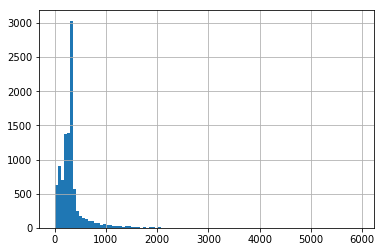

In [17]:
df_2["reviews.length"].hist(bins=100)

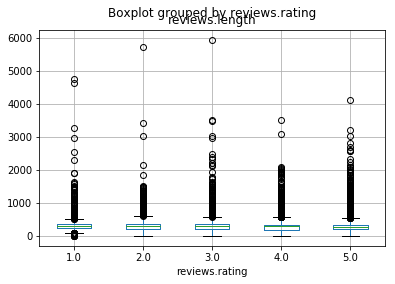

In [18]:
df_2.boxplot(column="reviews.length", by="reviews.rating")

In [19]:
orig_size = df_2["reviews.text"].count()

df_2 = df_2[df_2["reviews.length"].between(LOWER_BOUND, UPPER_BOUND)]


new_size = df_2["reviews.text"].count()

print("Number of records in pruned dataset: {}", new_size)
print("Percentage of records kept: %{}", (new_size/orig_size * 100))

Number of records in pruned dataset: {} 7474
Percentage of records kept: %{} 74.74747474747475


### 2.3 Dataset 3

5    4840
4    2849
3    1190
1     567
2     554
Name: reviews.rating, dtype: int64


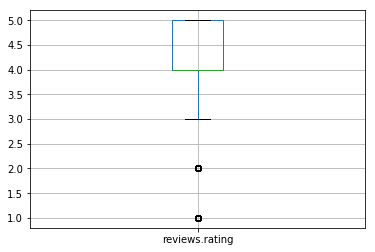

In [20]:
df_3 = load_dataset(DATASET_3)

df_3.head()

df_3.boxplot(column="reviews.rating")
print(df_3["reviews.rating"].value_counts())

In DATASET_3, all of the reviews are already on the integer 1-5 scale, so there is nothing that needs to be done.

count    10000.000000
mean       651.899600
std        593.559418
min          8.000000
25%        302.000000
50%        462.000000
75%        812.250000
max      14254.000000
Name: reviews.length, dtype: float64


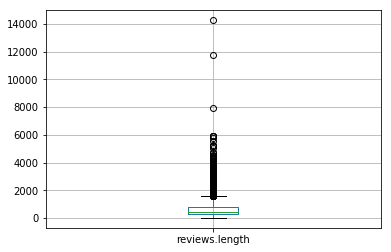

In [21]:
df_3["reviews.length"] = df_3["reviews.text"].str.len()

print(df_3["reviews.length"].describe())

df_3.boxplot(column="reviews.length")


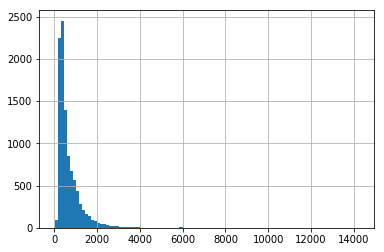

In [22]:
df_3["reviews.length"].hist(bins=100)

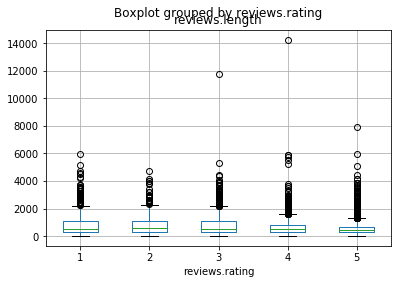

In [23]:
df_3.boxplot(column="reviews.length", by="reviews.rating")

In [24]:
orig_size = df_3["reviews.text"].count()

df_3 = df_3[df_3["reviews.length"].between(LOWER_BOUND, UPPER_BOUND)]


new_size = df_3["reviews.text"].count()

print("Number of records in pruned dataset: {}".format(new_size))
print("Percentage of records kept: {}%".format(new_size/orig_size * 100))

Number of records in pruned dataset: 4871
Percentage of records kept: 48.71%


Using the Upper and Lower length bounds for Dataset 1 here have resulted in a significantly larger number of records being eliminated. This suggests that this set of reviews is obtained from a different source, or using a different scraper system, and so may have different underlying properties (eg. if these reviews are obtained from a different website, the users of that website may have a different interpretation of the review scale).

While I have decided to simply include the dataset as is, a more robust analysis to properly understand the differences between this dataset and the others could be very useful in improving any statistical models trained.

### 2.4 Combining the Three Datasets

In [25]:
#Find the columns that are present in each of the three datasets, and make sure that there aren't any important columns
# (review text, title, rating, etc.) that are functionally identical, but named differently
columns_intersection = set.intersection(set(df_1.columns.values),set(df_2.columns.values), set(df_3.columns.values))
print(columns_intersection)

{'reviews.date', 'longitude', 'reviews.userProvince', 'reviews.rating', 'categories', 'postalCode', 'latitude', 'reviews.length', 'reviews.username', 'name', 'city', 'province', 'reviews.title', 'address', 'reviews.text', 'reviews.userCity', 'country'}


In [26]:
#now concatenate the chosen data sources on the schema intersection

df = pd.concat([df_1,df_2,df_3], join="inner")

#remove unnecessary columns
df = df[["reviews.rating", "reviews.text", "reviews.length"]]


#remove reviews with the same rating and text
df = df.drop_duplicates()

df = df.reset_index(drop=True)

print(df.head())

print(len(df))

   reviews.rating                                       reviews.text  \
0             4.0  b"Pleasant 10 min walk along the sea front to ...   
1             5.0  b"Really lovely hotel. Stayed on the very top ...   
2             5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3             5.0  b'We stayed here for four nights in October. T...   
4             5.0  b'We loved staying on the island of Lido! You ...   

   reviews.length  
0             194  
1             252  
2             136  
3             354  
4             326  
34223


In [27]:
print(df.loc[789,:])

reviews.rating                                                    5
reviews.text      b'Americinn on the Au Sable river is a gem! Ve...
reviews.length                                                  327
Name: 789, dtype: object


In [28]:
df.count()

reviews.rating    34223
reviews.text      34223
reviews.length    34223
dtype: int64

In [29]:
df[df["reviews.text"] == ""]


,reviews.rating,reviews.text,reviews.length


## 3. Translation of non-English reviews 

In [31]:
print("Total number of characters in dataset: {:,.0f}".format(df["reviews.length"].sum()))
print("At $20 per million characters, using google cloud translate would cost ${:,.2f}".format(df["reviews.length"].sum() / 1000000 * 20))

Total number of characters in dataset: 9,075,527
At $20 per million characters, using google cloud translate would cost $181.51


Given the cost of detecting and translating the languages of each review, it is unfeasible for me to use this in any data analytics pipeline in this project. However, to examine the usefullness of translation as a pre-processing step, I will create a smaller dataset (1000 records) which will be translated and used in each sentiment analysis approach.

In [32]:
df_small = df.loc[0:999, :]

print(df_small.head())

print(len(df_small))
print("Total number of characters in dataset: {:,.0f}".format(df_small["reviews.length"].sum()))
print("At $20 per million characters, using google cloud translate would cost at least ${:,.2f}".format(df_small["reviews.length"].sum() / 1000000 * 20))

   reviews.rating                                       reviews.text  \
0             4.0  b"Pleasant 10 min walk along the sea front to ...   
1             5.0  b"Really lovely hotel. Stayed on the very top ...   
2             5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3             5.0  b'We stayed here for four nights in October. T...   
4             5.0  b'We loved staying on the island of Lido! You ...   

   reviews.length  
0             194  
1             252  
2             136  
3             354  
4             326  
1000
Total number of characters in dataset: 254,655
At $20 per million characters, using google cloud translate would cost at least $5.09


In [34]:
client = translate.Client()

#uses the google cloud translate API to detect the text language, returning the language and the confidence
def detect_language(text):

    #get the translation from the API (allowing for a few seconds to breathe when at the rate limit)
    while(True):
        try:
            detection = client.detect_language(text.decode("utf-8"))
        except Forbidden as e:
            #print(e.message)
            
            #if we're hitting the rate limit, wait a second and try again
            if e.message == "POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded":
                time.sleep(1)
                continue
            else: raise #otherwise, throw the error as usual
        break
        
    language = detection["language"]
    
    #because the API says that the confidence value is not always available, give a confidence value of 1 
    # (full confidence) if the confidence is not given to us
    
    confidence = detection["confidence"] if "confidence" in detection else 1
    
    return language, confidence
    
#uses the google cloud translate API to
#print(detect_language("aaaaaaa"))

def translate_text(text, source_lang="en", target_lang="en"):
    
    while(True):
        try:
            translation = client.translate(text.decode("utf-8"), source_language=source_lang, target_language=target_lang)
        except Forbidden as e:
            #if we're hitting the rate limit, wait a second and try again
            if e.message == "POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded":
                time.sleep(1)
                continue
            else: raise #otherwise, throw the error as usual
        except BadRequest as e:
                print(text.decode("utf-8"), " ", source_lang, "-", target_lang)
                raise
        break
    
    return translation["translatedText"].encode("utf-8")



In [35]:
def translate_dataframe(frame, redetect_languages=False, translator_functionality=TRANSLATOR_FUNCTIONALITY):
    
    #if selected, skip translating by just copying the untranslated text to the translated text column
    if USE_TRANSLATOR == False:
        frame["translated_text"] = frame["reviews.text"]
        return frame
    
    #skip if we already have detected languages and are not explicitly re-collecting them
    if ("detected_language" not in frame.columns) or (redetect_languages==True): 
        frame.loc[:,"detected_language"] = frame["reviews.text"].progress_map(detect_language)
        
    #save the detected languages so further testing and work doesn't require going through the process of
    #requesting language detection again
    df.to_csv("reviewratings_withlanguagedetection.csv")
    
    
    #now take all the reviews not in the source language and deal with them according to the functionality option set
    
    if translator_functionality == TRANSLATOR_OPTIONS.TRANSLATE:
        pass
        
        frame.loc[:,"translated_text"] = frame.progress_apply(lambda x: translate_text(x["reviews.text"], 
                                                                                 source_lang=x["detected_language"][0])
                                                            if x["detected_language"][0] != "en"
                                                            else x["reviews.text"]
                                                        ,axis=1) 
        
    elif translator_functionality == TRANSLATOR_OPTIONS.REMOVE:
        
        frame = frame[frame["detected_language"][0] == "en"]
        frame = frame.reset_index(drop=True)
        frame.loc[:,"translated_text"] = frame["reviews.text"]
        
    elif translator_functionality == TRANSLATOR_OPTIONS.THRESHOLD:
        
        frame = frame[frame["detected_language"][0] == "en" or frame["detected_language"][1] > TRANSLATOR_THRESHOLD]
        frame = frame.reset_index(drop=True)
        frame["translated_text"] = [row["reviews.text"] if row["detected_language"][0] == "en" 
                                    else translate_text(row["reviews.text"], source_lang=row["detected_language"][0])
                                    for row in frame]
        pass
    
    
    return frame

#test_df = df.head().copy()
#df_detected = translate_dataframe(test_df)
#print(df_detected["detected_language"].head())


In [70]:

#first test using the first 5 records (of which one is in swedish)

df_tiny = df.head().copy()

df_tiny = translate_dataframe(df_tiny)

print(df_tiny)


   reviews.rating                                       reviews.text  \
0             4.0  b"Pleasant 10 min walk along the sea front to ...   
1             5.0  b"Really lovely hotel. Stayed on the very top ...   
2             5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3             5.0  b'We stayed here for four nights in October. T...   
4             5.0  b'We loved staying on the island of Lido! You ...   

   reviews.length detected_language  \
0             194           (en, 1)   
1             252           (en, 1)   
2             136           (sv, 1)   
3             354           (en, 1)   
4             326           (en, 1)   

                                     translated_text  
0  b"Pleasant 10 min walk along the sea front to ...  
1  b"Really lovely hotel. Stayed on the very top ...  
2  b'A very good hotel. What pulled down the grad...  
3  b'We stayed here for four nights in October. T...  
4  b'We loved staying on the island of Lido! You ...  


In [41]:
#load_dataset("df_small.csv") # skip translating by loading a pre-translated dataframe

#detecting and translating the truncated dataset
df_small = translate_dataframe(df_small)

C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
print(df_small)
save_dataset(df_small, "df_small.csv")


     reviews.rating                                       reviews.text  \
0               4.0  b"Pleasant 10 min walk along the sea front to ...   
1               5.0  b"Really lovely hotel. Stayed on the very top ...   
2               5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3               5.0  b'We stayed here for four nights in October. T...   
4               5.0  b'We loved staying on the island of Lido! You ...   
5               4.0  b'ottimo soggiorno e ottima sistemazione nei g...   
6               3.0  b'Gnstiger Ausgangspunkt fr Venedig Besuche. R...   
7               4.0  b'Lidoen er perfekt til et par dages ro og afs...   
8               4.0  b'Accueil chaleureux, en franais Changement du...   
9               3.0  b'It was ok hotel is nice from in and out but ...   
10              4.0  b'Klasse Frhstck, freundliches und aufmerksame...   
11              4.0  b'Bardzo sympatyczna obsuga, klimat hotelu. wi...   
12              4.0  b'Bra o lugnt lge

[1000 rows x 5 columns]


## 4. Sentiment Analysis

### 4.1 Pros and Cons of Various Approaches

As with all Data Science problems, there are many possible solutions, each with different benefits and drawbacks specific to the nature of the approaches used and the assumptions underlying each model. For the purposes of this project, I have decided to implement four different approaches, and will evaluate the effectiveness of each (in terms of accuracy, time, cost, etc.).

The approaches I have chosen are as follows:


##### Google Natural Language API

This approach uses the Google Natural Language API to obtain a sentiment score for each review in the dataset.

Pros:
- Gold Standard Sentiment Scores trained on a large amount of data
- Able to handle complex sentence structure, negations, etc.
- Automatic Language Translation (for some languages)

Cons:
- Expensive - not viable for extremely large datasets
- Dependent on external APIs that may change of cease to exist

##### SentiWordNet Average Sentiment Scores

This approach looks up the SentiWordNet sentiment scores for each word in each review in the dataset, and assigns a score to each review using the average sentiment of each word.

Pros:
- Conceptually simple - models each word in the review as positive negative or neutral, and scores each review as the ratio of positive to negative words
- Word scores are not trained on the dataset, so no chance of overfitting and focussing on noise in the dataset

Cons:
- Unable to handle negations and complex sentence structure
- SentiWordNet scores are different for different definitions of the same word (ie. Great as in "large" has a different sentiment to Great as in "good"), and without manual tagging for definitions of each word, we have to default to one score, which may not be for the correct definition

##### Naive Bayes Classifier Sentiment Scores

This approach trains a Naive Bayes classifier to predict the rating of each review from the review text, and then assigns to each review a sentiment score using the class probabilities of the prediction (ie. a review that is given a 100% probability of having a 1.0 rating is assigned a score of -1, a review with a 100% probability of having a 5.0 rating is given a score of 1, and all reviews in between are placed in that range.

Pros:
- Quick to train
- Trained on the dataset, so word sentiments are more domain specific than models trained on other data sources

Cons:
- Trained on the dataset, so is reliant on the quality of the dataset - ie. wrongly labelled reviews may influence the results
- Assumes that each word in a review is independent of other words (completely false, but not always a problem)

##### LSTM Neural Network Classifier Sentiment Scores

This approach uses a Long Short Term Memory (LSTM) Neural Network - a Neural Network structure trained on a series of data points (in this case, each word in a review in order) that is informed by the memory of previous data points in the series, allowing it to make better use of the word's context in the review. This Neural Network is trained to predict the rating of the review based on the review text 

Pros:
- Should be able to capture negations and more complex sentence structure (ie. "this is not a good hotel" vs "this is a good hotel")
- Trained on the dataset, so reiew sentiments are more domain specific

Cons:
- Trained on the dataset, so is reliant on the quality of the dataset
- Complex Model Which will take much longer to train (than Naive Bayes, for example)
- Assumes linear relationship between text sentiment and 

### 4.2 Approach 1: Google Natural Language API

#### 4.2.1 Getting Google Sentiment Scores

In [73]:
# estimates the price for runnning sentiment analysis on a dataframe's reviews. This function assumes that this is
# the only use of the sentiment analysis API for the billing month, so actual prices may differ (as the first 
# 5000 units are free, and discounts are applied to units used after cetain thresholds are met on a monthly basis, not
# per use case), but this serves as a useful estimate when deciding whether to use this approach
def estimate_sentiment_price(frame):
    
    units = 0
    
    #print(len(frame["reviews.length"]))
    
    for i in frame["reviews.length"]:
        
        #print(i)
        #one unit for every 1000 characters in the text (rounded up)
        #
        #note: given that I have culled all reviews above 450 characters, all reviews here are worth 1 unit,
        # but this method will work to calculate units if I decide in future to include longer reviews
        units += math.ceil(i / 1000.0)
        
    price = 0
        
    while (units > 5000000):
        print(units)
        units -= 1000
        price += 0.25
            
    while units > 1000000:
        units -= 1000
        price += 0.5
            
    while units > 5000:
        units -= 1000
        price += 1
    
    return price    
    
print("Price to calculate sentiment scores for the entire cleaned dataset: ${:,.2f}".format(estimate_sentiment_price(df)))
print("Price to calculate sentiment scores for the truncated cleaned dataset: ${:,.2f}".format(estimate_sentiment_price(df_small)))






Price to calculate sentiment scores for the entire cleaned dataset: $30.00
Price to calculate sentiment scores for the truncated cleaned dataset: $0.00


Given the costs estimated above, it is not feasible to test this approach on the full dataset. However, like the Translation system, I will test the approach on the smaller dataset to see if the approach would be worth further examination if funds were available.

In [735]:
lang_client = language.LanguageServiceClient()

def get_google_sentiment_score(text):
    
    #print(text.decode("utf-8"))
    
    document = gc_types.Document(content=text.decode("utf-8"), type="PLAIN_TEXT")
    
    #make sure we dont hit against any rate limits
    while(True):
        try:
            response = lang_client.analyze_sentiment(document=document)
        except Forbidden as e:
            time.sleep(1)
            continue
        break

    
    sentiment = response.document_sentiment

    return sentiment.score
    
print(get_google_sentiment_score(b"This is Great!"))
    
print(get_google_sentiment_score(b"This sucks!"))

print(get_google_sentiment_score(b"I'm ambivalent about this!"))

print(get_google_sentiment_score(b"Tres bon!"))

0.8999999761581421
-0.8999999761581421
-0.30000001192092896
0.8999999761581421


#### 4.2.2 Scoring Each Review in the Dataset

In [77]:
def get_google_cloud_sentiment_scores_dataframe(frame):
    
    frame.loc[:,:]["gc_sentiment"] = frame["translated_text"].progress_map(get_google_sentiment_score)
    
    return frame
    
    
    

In [78]:
#test on the tiny dataset first to ensure that the API calls work

print(df_tiny)

df_tiny = get_google_cloud_sentiment_scores_dataframe(df_tiny)

print(df_tiny)

   Unnamed: 0  reviews.rating  \
0           0             4.0   
1           1             5.0   
2           2             5.0   
3           3             5.0   
4           4             5.0   

                                        reviews.text  reviews.length  \
0  b"Pleasant 10 min walk along the sea front to ...             194   
1  b"Really lovely hotel. Stayed on the very top ...             252   
2  b'Ett mycket bra hotell. Det som drog ner bety...             136   
3  b'We stayed here for four nights in October. T...             354   
4  b'We loved staying on the island of Lido! You ...             326   

  detected_language                                    translated_text  \
0         ('en', 1)  b"Pleasant 10 min walk along the sea front to ...   
1         ('en', 1)  b"Really lovely hotel. Stayed on the very top ...   
2         ('sv', 1)  b'A very good hotel. What pulled down the grad...   
3         ('en', 1)  b'We stayed here for four nights in October. T...  

   Unnamed: 0  reviews.rating  \
0           0             4.0   
1           1             5.0   
2           2             5.0   
3           3             5.0   
4           4             5.0   

                                        reviews.text  reviews.length  \
0  b"Pleasant 10 min walk along the sea front to ...             194   
1  b"Really lovely hotel. Stayed on the very top ...             252   
2  b'Ett mycket bra hotell. Det som drog ner bety...             136   
3  b'We stayed here for four nights in October. T...             354   
4  b'We loved staying on the island of Lido! You ...             326   

  detected_language                                    translated_text  \
0         ('en', 1)  b"Pleasant 10 min walk along the sea front to ...   
1         ('en', 1)  b"Really lovely hotel. Stayed on the very top ...   
2         ('sv', 1)  b'A very good hotel. What pulled down the grad...   
3         ('en', 1)  b'We stayed here for four nights in October. T...  

In [79]:
df_small = get_google_cloud_sentiment_scores_dataframe(df_small)





C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### 4.2.3 Evaluating Resultant Sentiment Scores

In [82]:
print(df_small.loc[9,:])

reviews.rating                                                       3
reviews.text         b'It was ok hotel is nice from in and out but ...
reviews.length                                                     112
detected_language                                              (en, 1)
translated_text      b'It was ok hotel is nice from in and out but ...
gc_sentiment                                                      -0.2
Name: 9, dtype: object


In [91]:
print("Pearson co-efficient: ",df_small["reviews.rating"].corr(df_small["gc_sentiment"]))
print("Spearman co-efficient: ",df_small["reviews.rating"].corr(df_small["gc_sentiment"], method="spearman"))

Pearson co-efficient:  0.6544873197926278
Spearman co-efficient:  0.5898236866015896


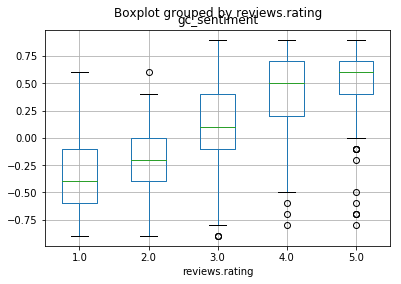

In [97]:
df_small.boxplot(column="gc_sentiment", by="reviews.rating")


With a correlation coefficient of ~+0.65, this method of obtaining sentiment scores seems to be very highly correlated 

<Figure size 432x288 with 0 Axes>

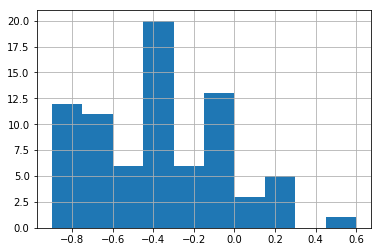

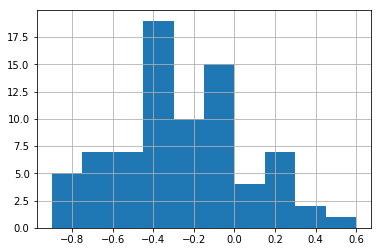

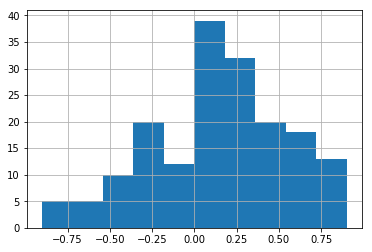

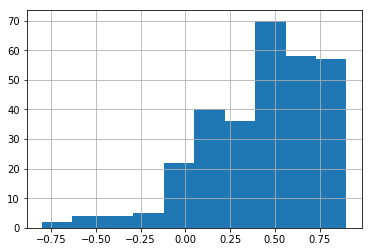

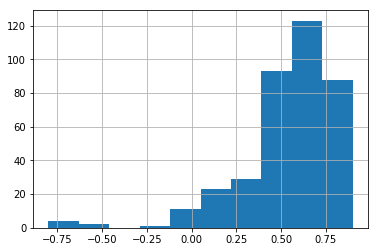

<Figure size 432x288 with 0 Axes>

In [933]:
df_small[df_small["reviews.rating"] == 1.0]["gc_sentiment"].hist()
plt.figure()
df_small[df_small["reviews.rating"] == 2.0]["gc_sentiment"].hist()
plt.figure()
df_small[df_small["reviews.rating"] == 3.0]["gc_sentiment"].hist()
plt.figure()
df_small[df_small["reviews.rating"] == 4.0]["gc_sentiment"].hist()
plt.figure()
df_small[df_small["reviews.rating"] == 5.0]["gc_sentiment"].hist()
plt.figure()

The distributions of scores for each rating, as shown in the histograms above, show a clear difference in the sentiments for reviews of different ratings - 5.0 rated reviews on average have a higher sentiment score than 3.0 rated scores, and a much higher sentiment than 1.0 rated scores. However, the small number of scores available (particularly for the lower-rated reviews) makes it difficult to properly evaluate the distributions

#### 4.2.4 Calculating Difference between Sentiment Score and Rating

To generate scores representing a the difference between the obtained sentiment scores and the given ratings, I will remap the sentiment scores from the range -1.0 to +1.0 to 1.0-5.0, and calculate the absolute difference between that and the review rating 

In [146]:
def remap_range(input, input_range=(-1.0,1.0),output_range=(1.0,5.0)):
    return ( (input - input_range[0]) / (input_range[1] - input_range[0]) ) * (output_range[1] - output_range[0]) + output_range[0]    

def remap_sentiment_score(input):
    
    return remap_range(input, input_range=(-1.0,1.0), output_range=(1.0,5.0)) 


#print(remap_sentiment_rating(-1))

def get_sentiment_difference_score(sentiment_score,rating):

    #remap the sentiment scores to the rating range (ie. 1.0-5.0)
    remapped_sentiment_score = remap_sentiment_score(sentiment_score)
    #print(remapped_sentiment_score)
    
    
    #get the absolute difference between the two and reverse it
    score_difference = 4 - abs(remapped_sentiment_score - rating)
    
    #print(score_difference)

    return remap_range(score_difference, input_range=(0.0,4.0), output_range=(0.0,1.0))


#make sure these functions do as they are expected
assert remap_sentiment_score(1.0) == 5
assert remap_sentiment_score(-1.0) == 1

assert get_sentiment_difference_score(1,5) == 1
assert get_sentiment_difference_score(-1,5) == 0


In [669]:
df_small["gc_sentiment_difference_rating"] = df_small.apply(lambda x: 
                                                            get_sentiment_difference_score(x["gc_sentiment"],
                                                                                          x["reviews.rating"]),
                                                           axis=1)




<Figure size 432x288 with 0 Axes>

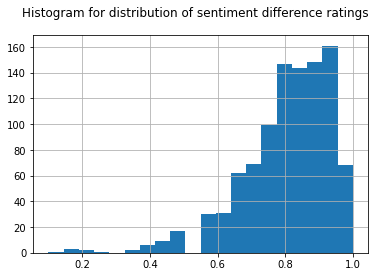

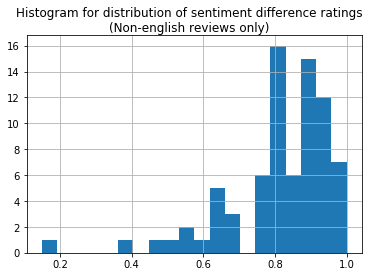

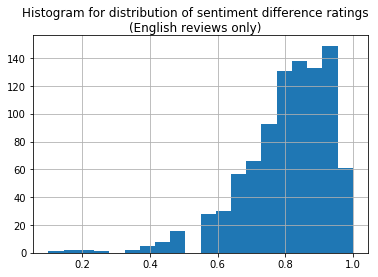

<Figure size 432x288 with 0 Axes>

In [671]:

df_small["gc_sentiment_difference_rating"].hist(bins=20)
plt.suptitle("Histogram for distribution of sentiment difference ratings")
plt.figure()

df_small[df_small["detected_language"].str[0] != "en"]["gc_sentiment_difference_rating"].hist(bins=20)
plt.suptitle("Histogram for distribution of sentiment difference ratings\n(Non-english reviews only)")
plt.figure()

df_small[df_small["detected_language"].str[0] == "en"]["gc_sentiment_difference_rating"].hist(bins=20)
plt.suptitle("Histogram for distribution of sentiment difference ratings\n(English reviews only)")
plt.figure()

Looking at the histograms for sentiment difference ratings, we can see that most reviews are given a very high score, indicating that there is a very high correlation between sentiment score and rating. This seems to be only slightly affected by whether the reviews were translated from a non-english language, suggesting that the Google translate system does well at keeping relevant sentiment informtion when translating.

Hoewver, there are a small number where the sentiment score and the given review rating are very discordant, and it would be worthwhile to drill into those reviews to examine where the discrepancy lies.

In [165]:
#sort the df by sentiment difference rating, and get the lowest 20 reviews to examine individually
df_worst_scores = df_small.sort_values("gc_sentiment_difference_rating").head(20)

df_worst_scores.loc[:,["translated_text", "reviews.rating", "gc_sentiment", "detected_language", "gc_sentiment_difference_rating"]]

,translated_text,reviews.rating,gc_sentiment,detected_language,gc_sentiment_difference_rating
755,b'the free wifii was very slow -- had to pay f...,5.0,-0.8,"(en, 1)",0.10
777,"b'The hotel was on the whole okay, only the su...",5.0,-0.7,"(de, 1)",0.15
86,"b""Let's face it, this is NOT in the Livermore ...",5.0,-0.7,"(en, 1)",0.15
911,b'It was terrible. Would never stayhere agian....,5.0,-0.7,"(en, 1)",0.15
793,b'We had our family reunion there and it was a...,1.0,0.6,"(en, 1)",0.20
177,"b'The rooms were OK, but there was no insulati...",5.0,-0.6,"(en, 1)",0.20
827,b'Great break but tv channels were not availab...,5.0,-0.5,"(en, 1)",0.25
428,b'The food at breakfast was good but we had to...,4.0,-0.8,"(en, 1)",0.35
810,"b""We've lived in the area for twelve years but...",1.0,0.3,"(en, 1)",0.35
892,b'After 22hrs. of driving all I was looking fo...,1.0,0.2,"(en, 1)",0.40


In [171]:
print(df_worst_scores.loc[755,:]["translated_text"].decode("utf-8"), "\n")

print(df_worst_scores.loc[777,:]["translated_text"].decode("utf-8"), "\n")

print(df_worst_scores.loc[775,:]["translated_text"].decode("utf-8"), "\n")

print(df_worst_scores.loc[867,:]["translated_text"].decode("utf-8"), "\n")

the free wifii was very slow -- had to pay for wifii (price was ok) one can only get 3 devices online - they should increase the number of devices now that everyone carries at least a smart phone, ipad and maybe a laptop 

The hotel was on the whole okay, only the surrounding area with the construction site was not so exciting 

The hotel was on the whole okay, only the surrounding area with the construction site was not so exciting 

You can learn your way around with the green QR code tour. Use SCVNGR on property to get 1/2 off an appetizer or write a review online to win a $100 gift card! 



Examining these reviews in closer detail shows that for most of these, the sentiment scores seem to align with a naive understanding of the text of the review (if a review *seems* negative, that is reflected in the sentiment score). This suggests that maybe the scraper used to create the dataset is occasionally asssigning the wrong review text to each rating. This hypothesis is given further creedence by the fact that two of the reviews (namely reviews 775 and 777) in the selection above have the exact same text.   

### 4.3 Approach 2: SentiWordNet Average Sentiment Scores

In [206]:
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
nltk.download('wordnet')
    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

#### 4.3.1 Defining the Scoring Function

In [730]:

def penn_tag_to_wn_tag(tag):
    
    wn_tag = ""
    
    if tag.startswith("NN"): 
        wn_tag = wn.NOUN
    elif tag.startswith("VB"):
        wn_tag = wn.VERB
    elif tag.startswith("JJ"):
        wn_tag = wn.ADJ
    elif tag.startswith("RB"):
        wn_tag = wn.ADV
    
    return wn_tag
    

def get_swn_sentiment_scores(text):
    
    #tokenise 
    words = nltk.word_tokenize(text)
    
    pos_tags = nltk.pos_tag(words)
    
    
    pos_tags = [(i[0], penn_tag_to_wn_tag(i[1])) for i in pos_tags if penn_tag_to_wn_tag(i[1]) != ""]
    
    
    lem = WordNetLemmatizer()
    
    
    synsets = [(lem.lemmatize(i[0], i[1]), i[1]) for i in pos_tags]
    synsets = [list(swn.senti_synsets(i[0],i[1])) for i in synsets]
    
    #print(len(senti_scores))
    
    scores = []
    for i in range(0, len(synsets)):
        
        if (len(synsets[i]) == 0):
            continue #ignore words which dont have a synset
        
        synset = synsets[i][0]
        
        scores.append({"pos_score" : synset.pos_score(),
                       "neg_score" : synset.neg_score()})
    
    return scores

#print(list(swn.senti_synsets("good", "n")))

def get_average_swn_sentiment_score(text):
    
    scores = get_swn_sentiment_scores(text)
    
    score = 0
    emotive_words = 0
    
    #if there arent any synsets in the text, return neutral
    if len(scores) == 0:
        return 0
    
    for i in scores:
        #print(i)
        if ((i["pos_score"] != 0) or (i["neg_score"] != 0)):
            emotive_words += 1
            
        
        score += i["pos_score"]
        score -= i["neg_score"]
            
    if (emotive_words == 0):
        return 0 #if there were no words with emotive content in the review return neutral

    return score / emotive_words

scores1 = "this is a bad hotel with good wifi and wonderful ambience"
scores2 = "this isnt a bad hotel"
scores3 = "I am ambivalent about this hotel and wish it was better"
scores4 = "...no problems with this hotel exept that the pool was small"
scores5 = "good hotel good fun. loved it"
        
print(get_average_swn_sentiment_score(scores1))
print(get_average_swn_sentiment_score(scores2))
print(get_average_swn_sentiment_score(scores3))
print(get_average_swn_sentiment_score(scores4))
print(get_average_swn_sentiment_score(scores5))




0.25
-0.625
-0.05
-0.2916666666666667
0.59375


#### 4.3.2 Scoring Each Review in the Dataset

In [731]:
df["swn_sentiment_score"] = [get_average_swn_sentiment_score(text.decode("utf-8")) 
                             for text in tqdm(df["reviews.text"].values)]

#### 4.3.3 Evaluating Resultant Sentiment Scores

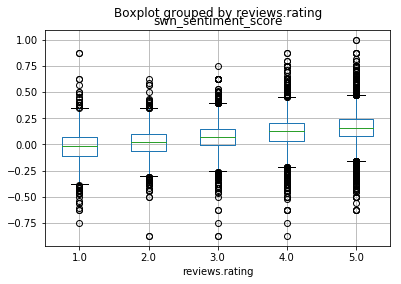

In [732]:
df.boxplot(column="swn_sentiment_score", by="reviews.rating")

<Figure size 432x288 with 0 Axes>

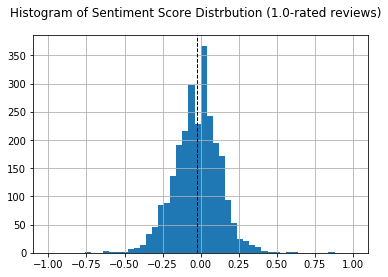

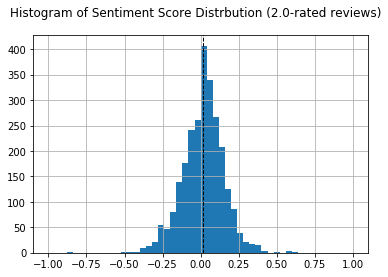

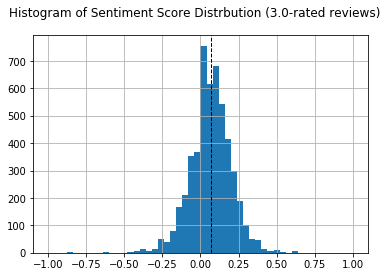

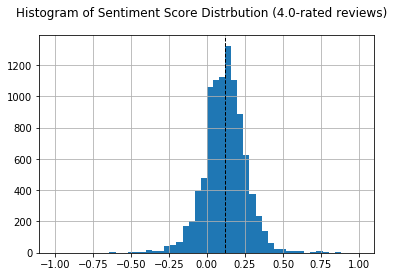

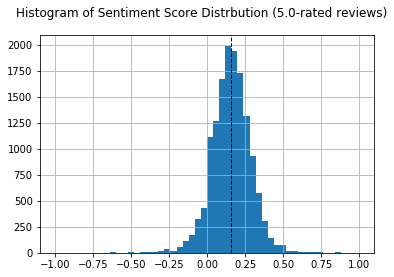

<Figure size 432x288 with 0 Axes>

In [939]:
df[df["reviews.rating"] == 1.0]["swn_sentiment_score"].hist(bins=50, range=(-1, 1))
#draw a line at the mean value in the histogram
plt.axvline(df[df["reviews.rating"] == 1.0]["swn_sentiment_score"].mean(), color='k', linestyle='dashed', linewidth=1)
plt.suptitle("Histogram of Sentiment Score Distrbution (1.0-rated reviews)")
plt.figure()
df[df["reviews.rating"] == 2.0]["swn_sentiment_score"].hist(bins=50, range=(-1, 1))
plt.axvline(df[df["reviews.rating"] == 2.0]["swn_sentiment_score"].mean(), color='k', linestyle='dashed', linewidth=1)
plt.suptitle("Histogram of Sentiment Score Distrbution (2.0-rated reviews)")
plt.figure()
df[df["reviews.rating"] == 3.0]["swn_sentiment_score"].hist(bins=50, range=(-1, 1))
plt.axvline(df[df["reviews.rating"] == 3.0]["swn_sentiment_score"].mean(), color='k', linestyle='dashed', linewidth=1)
plt.suptitle("Histogram of Sentiment Score Distrbution (3.0-rated reviews)")
plt.figure()
df[df["reviews.rating"] == 4.0]["swn_sentiment_score"].hist(bins=50, range=(-1, 1))
plt.axvline(df[df["reviews.rating"] == 4.0]["swn_sentiment_score"].mean(), color='k', linestyle='dashed', linewidth=1)
plt.suptitle("Histogram of Sentiment Score Distrbution (4.0-rated reviews)")
plt.figure()
df[df["reviews.rating"] == 5.0]["swn_sentiment_score"].hist(bins=50, range=(-1, 1))
plt.axvline(df[df["reviews.rating"] == 5.0]["swn_sentiment_score"].mean(), color='k', linestyle='dashed', linewidth=1)
plt.suptitle("Histogram of Sentiment Score Distrbution (5.0-rated reviews)")
plt.figure()

Here, the boxplot distribution histograms show a very slight increase in mean sentiment score as the rating of the review increases. Howeer, these means are very tightly packed around zero, suggesting that 

In [747]:
df.loc[:,["reviews.rating", "swn_sentiment_score"]].corr()

,reviews.rating,swn_sentiment_score
reviews.rating,1.000000,0.388954
swn_sentiment_score,0.388954,1.000000


#### 4.3.4 Calculating Difference between Sentiment Score and Rating

<Figure size 432x288 with 0 Axes>

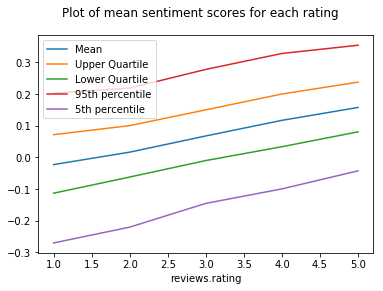

<Figure size 432x288 with 0 Axes>

In [960]:
scores_grouped = df.groupby("reviews.rating")["swn_sentiment_score"]

pd.DataFrame({"Mean" : scores_grouped.mean(), 
              "Upper Quartile": scores_grouped.quantile(0.75),
              "Lower Quartile": scores_grouped.quantile(0.25),
              "95th percentile": scores_grouped.quantile(0.95),
              "5th percentile": scores_grouped.quantile(0.05),
             }).plot()
print(quantiles)
plt.suptitle("Plot of mean sentiment scores for each rating")
plt.figure()

Because there is a much greater range of scores within each rating compared to the inter-rating ranges, I have decided to use a Decision Tree regressor to rescale the sentiment scores into the 1.0-5.0 rating scale. This should prevent problems such as unusually high or low sentiment scores being rescaled into ratings higher or lower than the maximum or minimum, and thus being given a poor difference score even though the sentiment corresponds well to the given rating.

In [955]:
reg = LinearRegression().fit(df["swn_sentiment_score"].values.reshape(-1,1), df["reviews.rating"].values)

dt = DecisionTreeRegressor().fit(df["swn_sentiment_score"].values.reshape(-1,1), df["reviews.rating"].values)

print("Linear Regressor Score: {:.2f}".format(reg.score(df["swn_sentiment_score"].values.reshape(-1,1), df["reviews.rating"].values)))
print("Decision Tree Score: {:.2f}".format(dt.score(df["swn_sentiment_score"].values.reshape(-1,1), df["reviews.rating"].values)))


Linear Regressor Score: 0.15
Decision Tree Score: 0.20


Immediately, the poor accuracy scores for both regressors (though the Decision Tree regressor fares slightly better) suggests that this approach is not effective for accurately gauging the sentiment of reviews. Still, it is worthwhile to examine the reviews for which the scorer fares worst to see exactly why this approach isn't effective, and possibly glean insight into how this or other approaches could be improved.

In [956]:
predicted_ratings = dt.predict(df["swn_sentiment_score"].values.reshape(-1,1))

df["swn_score_difference"] = abs(df["reviews.rating"] - predicted_ratings)

In [957]:
worst_performers = (df.sort_values("swn_score_difference", ascending=False).head(20))

In [959]:
for idx, row in worst_performers.iterrows():
    print(i)
    print(idx, "\t", 
          "Rating: {}".format(row["reviews.rating"]), "\t",
          "Sentiment Score: {:,.2f}".format(row["swn_sentiment_score"]), "\t",
          "Difference Score: {:,.2f}".format(row["swn_score_difference"])) 
    print(row["reviews.text"].decode("utf-8"))

reviews.rating
25050 	 Rating: 1.0 	 Sentiment Score: 0.35 	 Difference Score: 3.69
Nice location and convenient to the beach. The property is pretty old and outdated. The room had to many cockroaches. Cockroaches were on the desk and in the furniture. Would be nice if the rooms were pest free.
reviews.rating
9106 	 Rating: 1.0 	 Sentiment Score: 0.34 	 Difference Score: 3.63
I wont stay there again, I will next time pay for better hotel just sucked that everywhere else was booked. Asked 3 times for towels.
reviews.rating
16950 	 Rating: 1.0 	 Sentiment Score: 0.48 	 Difference Score: 3.56
Don't stay here ! Checked in and 15 min later was on the phone looking for a decent hotel, an hour later I checked out. .The sign they had at the front desk said .....No Refunds... found out really fast why !!!
reviews.rating
12539 	 Rating: 1.0 	 Sentiment Score: 0.26 	 Difference Score: 3.55
We had booked this hotel for a long weekend from March 6 thru 8. It was a family getaway. We had booked a tw

Looking at the worst performing reviews in terms of the difference between the sentiment score and the rating, we can see that this approach has major shortcomings. For nearly all of these reviews, it is clear that the sentiment of the reviews is in accordance with the rating, but the scorer is unable to see this. This seems to be mostly because of the context of the positive and negative words in the review - for example, review 16950 uses the phrase "15 min later was on the phone looking for a decent hotel", and review 25050 uses "Would be nice if the rooms were pest free.", both clearly negative phrases but ones which the scorer would score as positive because of the word choices used ("decent", "nice", "free").

### 4.4 Approach 3: Naive Bayes Classifier Sentiment Scores

#### 4.4.1 Text Preprocessing

In [775]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [997]:
ps = PorterStemmer()

stoplist = set(stopwords.words("english"))

#preprocessor
def preprocessor(text):
    
    #transliterate non-unicode characters
    text = unidecode(text)
    
    #replace apostrophes with ""
    text = text.replace("'", "")
    
    #and all other punctuation with a space
    text = text.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))
    
    #lowercase it
    text = text.lower()
    
    return text
    
def tokenizer(text):
    
    #split on whitespace
    tokens = text.split(" ")
    
    #remove empty tokens
    tokens = [token for token in tokens if token != ""]
    
    #get rid of extremely common words using a stoplist
    tokens = [token for token in tokens if token not in stoplist]
    
    
    #use a porter stemmer to reduce all tokens to a representation of their base form    
    tokens = [ps.stem(token) for token in tokens]
    
    return tokens

print(unidecode("日本国"))

print(tokenizer(preprocessor("日本国..' careening' isn't a carpets.the.archaeologists generously ")))
print(tokenizer(preprocessor("Fue muy agradable mi estancia en el hotel, el personal muy profesional y amable, las instalaciones muy limpias y cmodas, el servicio excelente!!! el desayuno muy rico tambin, todo el personal muy servicial, tuve muy buena experiencia, adems de que se encuentra muy bien ubicado, ya que est enfrente una plaza comercial")))

print(tokenizer(preprocessor("isn’t"))) #different apostrophe - not '

Ri Ben Guo 
['ri', 'ben', 'guo', 'careen', 'isnt', 'carpet', 'archaeologist', 'gener']
['fue', 'muy', 'agrad', 'mi', 'estancia', 'en', 'el', 'hotel', 'el', 'person', 'muy', 'profesion', 'amabl', 'la', 'instalacion', 'muy', 'limpia', 'cmoda', 'el', 'servicio', 'excelent', 'el', 'desayuno', 'muy', 'rico', 'tambin', 'todo', 'el', 'person', 'muy', 'servici', 'tuve', 'muy', 'buena', 'experiencia', 'adem', 'de', 'que', 'se', 'encuentra', 'muy', 'bien', 'ubicado', 'ya', 'que', 'est', 'enfrent', 'una', 'plaza', 'comerci']
['isnt']


In [1001]:
texts = [x.decode() for x in df["reviews.text"].values]


cv = CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer)

X = cv.fit_transform(texts)

In [1002]:
print(X[3])

  (0, 21031)	1
  (0, 13470)	1
  (0, 18598)	1
  (0, 4191)	1
  (0, 15264)	1
  (0, 2562)	1
  (0, 22035)	1
  (0, 14206)	1
  (0, 5016)	1
  (0, 22090)	1
  (0, 1264)	1
  (0, 11686)	1
  (0, 17985)	1
  (0, 4334)	1
  (0, 14209)	1
  (0, 19963)	1
  (0, 3064)	1
  (0, 1966)	1
  (0, 21886)	1
  (0, 14032)	1
  (0, 13667)	1
  (0, 8103)	1
  (0, 9435)	1
  (0, 8231)	1
  (0, 18818)	1
  (0, 18910)	1
  (0, 17050)	2
  (0, 8832)	1
  (0, 3207)	1
  (0, 4577)	2
  (0, 9764)	2


#### 4.4.2 Train-Test Split

In [1003]:
sentiments =  df["reviews.rating"]
#print(sentiments[0:5])

le = LabelEncoder()
le.fit([1,2,3,4,5])

Y = le.transform(sentiments)

print(len(Y[Y == 0]))

2557


In [1004]:
X_train, X_test, Y_train, Y_test, ratings_train, ratings_test = train_test_split(X, Y, ratings,
                                                                                 test_size=TEST_PROPORTION)

print(X_train.shape)

(25667, 22574)


#### 4.4.3 Fitting and Evaluating the Model

In [1005]:
bayes = MultinomialNB()

bayes.fit(X_train, Y_train)

pred_y = bayes.predict(X_test)

In [1006]:
print(Y_test)
print(pred_y)

conf = confusion_matrix(Y_test, pred_y)

[4 4 3 ... 3 4 3]
[4 4 3 ... 3 3 3]


In [1007]:
train_preds = bayes.predict(X_train)

accuracy = accuracy_score(Y_train, train_preds)
print("Train Set Accuracy: {:.2f}".format(accuracy))


Train Set Accuracy: 0.67


In [1008]:
accuracy = accuracy_score(Y_test, pred_y)
print("Test Set Accuracy: {:.2f}".format(accuracy))

Test Set Accuracy: 0.54


In [1009]:
probs = bayes.predict_proba(X_test)
print(probs)

[[5.39055916e-08 9.00477554e-05 1.26629838e-02 3.22329308e-01
  6.64917607e-01]
 [1.20158819e-08 2.75728303e-08 1.50183142e-04 1.12790029e-01
  8.87059748e-01]
 [6.46331315e-15 1.64434146e-08 3.22965599e-02 9.66345770e-01
  1.35765361e-03]
 ...
 [3.66813104e-05 1.27608879e-04 1.50413249e-02 8.97757610e-01
  8.70367750e-02]
 [3.86494187e-07 4.78841270e-05 2.05422507e-02 8.93003473e-01
  8.64060055e-02]
 [8.52651092e-02 3.82637331e-03 9.37534595e-05 9.10814742e-01
  2.16133055e-08]]


This model seems to be slightly overfit, as the accuracy of predictions for the training set is a fair bit higher than the accuraacy for the test set.

#### 4.4.4 Scoring Each Text in the Dataset

In [1010]:
def get_naive_bayes_score(probs):
    
    return (-1*probs[:,0]) + (-0.5*probs[:,1]) + (0.5*probs[:,3]) + (1*probs[:,4])

probs = bayes.predict_proba(X)

df["naive_bayes_sentiment_score"] = get_naive_bayes_score(probs)

#### 4.4.5 Evaluating Resultant Sentiment Scores 

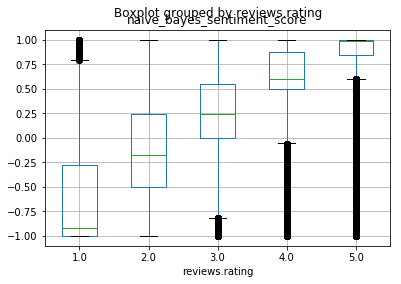

In [1011]:
df.boxplot(column="naive_bayes_sentiment_score", by="reviews.rating")

<Figure size 432x288 with 0 Axes>

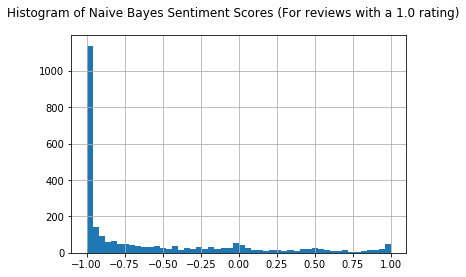

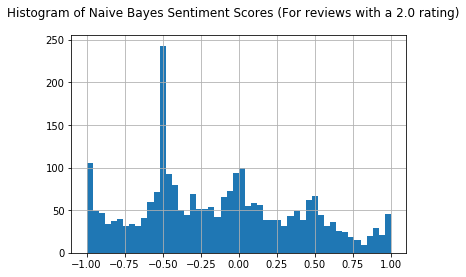

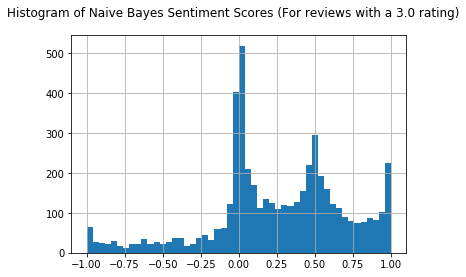

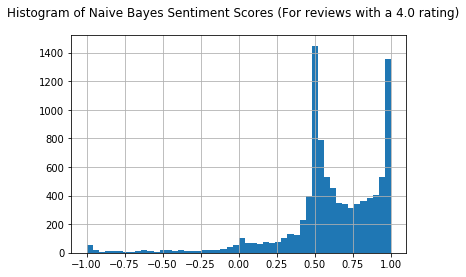

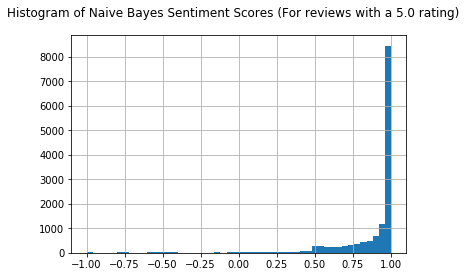

<Figure size 432x288 with 0 Axes>

In [1012]:
df[df["reviews.rating"] == 1.0]["naive_bayes_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Naive Bayes Sentiment Scores (For reviews with a 1.0 rating)")
plt.figure()
df[df["reviews.rating"] == 2.0]["naive_bayes_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Naive Bayes Sentiment Scores (For reviews with a 2.0 rating)")
plt.figure()
df[df["reviews.rating"] == 3.0]["naive_bayes_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Naive Bayes Sentiment Scores (For reviews with a 3.0 rating)")
plt.figure()
df[df["reviews.rating"] == 4.0]["naive_bayes_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Naive Bayes Sentiment Scores (For reviews with a 4.0 rating)")
plt.figure()
df[df["reviews.rating"] == 5.0]["naive_bayes_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Naive Bayes Sentiment Scores (For reviews with a 5.0 rating)")
plt.figure()

From the histograms, we can see that the sentiment scores are highly correlated with the review ratings (as expected, given that the Naive Bayes model is trained using a large portion of them). However, the fact that the distributions for each review rating have very large peaks at the corresponding sentiment scores for each rating, rather than a smooth curve centred around the corresponding score as all the other approaches lead to, indicates that the model may be overfitting to the rating, and isn't properly embodying the sentiment of the text - we would expect, given that each review writer has their own idea of how their opinion of a place translates to a score rating, a higher variation of scores for each rating - ie. 4.0-rated reviews with text that, for most people, would be grounds to give a 5.0.

#### 4.4.6 Calculating Difference between Sentiment Score and Rating

Text(0.5,0.98,'Plot of mean sentiment scores for each rating')

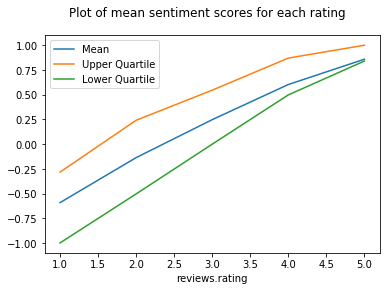

In [1013]:
scores_grouped = df.groupby("reviews.rating")["naive_bayes_sentiment_score"]

pd.DataFrame({"Mean" : scores_grouped.mean(), 
              "Upper Quartile": scores_grouped.quantile(0.75),
              "Lower Quartile": scores_grouped.quantile(0.25),
#              "95th percentile": scores_grouped.quantile(0.95),
#              "5th percentile": scores_grouped.quantile(0.05),
             }).plot()
print(quantiles)
plt.suptitle("Plot of mean sentiment scores for each rating")

In [1014]:
reg = LinearRegression().fit(df["naive_bayes_sentiment_score"].values.reshape(-1,1), df["reviews.rating"].values)

print("Score: {:.2f}".format(reg.score(df["naive_bayes_sentiment_score"].values.reshape(-1,1), df["reviews.rating"].values)))

Score: 0.56


In [1015]:
predicted_ratings = reg.predict(df["naive_bayes_sentiment_score"].values.reshape(-1,1))

df["naive_bayes_score_difference"] = abs(df["reviews.rating"] - predicted_ratings)

In [1016]:
worst_performers = (df.sort_values("naive_bayes_score_difference", ascending=False).head(20))

In [1017]:
for idx, row in worst_performers.iterrows():
    print(idx, "\t", 
          "Rating: {}".format(row["reviews.rating"]), "\t",
          "Sentiment Score: {:,.2f}".format(row["naive_bayes_sentiment_score"]), "\t",
          "Difference Score: {:,.2f}".format(row["naive_bayes_score_difference"])) 
    print(row["reviews.text"].decode("utf-8"))

5509 	 Rating: 1.0 	 Sentiment Score: 1.00 	 Difference Score: 3.69
Recently my wife Diana and I visited this hotel was wonderfully taken care of by the top-notch receptionist Scott. He even found a little treat for our dog Spencer. Also the hotel was immaculate we love all the amenities. David Allport
22090 	 Rating: 1.0 	 Sentiment Score: 1.00 	 Difference Score: 3.69
Elk Springs We went with 3 children.As soon as you walk in you feel like you're at home. It has all the perks of home and is extremely affordable. I highly reccomend a stay at elk springs.
5115 	 Rating: 1.0 	 Sentiment Score: 1.00 	 Difference Score: 3.69
Classic Style Grace This is a wonderful hotel and we would recommend it highly to anyone staying in Portland. Beautifully appointed lobby and rooms, friendly professional staff, comfortable and cozy - from the fireplace in the lobby to the private balcony and view of the City.
22023 	 Rating: 1.0 	 Sentiment Score: 1.00 	 Difference Score: 3.69
We recently revisited E

In [1018]:
worst_performers_five_stars = (df[df["reviews.rating"] == 5.0].sort_values("naive_bayes_score_difference", ascending=False).head(20))

In [1019]:
for idx, row in worst_performers_five_stars.iterrows():
    print(idx, "\t", 
          "Rating: {}".format(row["reviews.rating"]), "\t",
          "Sentiment Score: {:,.2f}".format(row["naive_bayes_sentiment_score"]), "\t",
          "Difference Score: {:,.2f}".format(row["naive_bayes_score_difference"])) 
    print(row["reviews.text"].decode("utf-8"))

7474 	 Rating: 5.0 	 Sentiment Score: -1.00 	 Difference Score: 3.57
Mycket bra hotell, med fantastisk service. Bodde ven ngra dagar p systerhotellet Villa Ducale, men Carlotta var nog snppet bttre pga lget. Bara ngra minuters promenad direkt till restauranger och huvudgata. Fin trdgrd med pool, samt mysig restaurang/frukost/drinkbar i toppen av hotellet. Utsikt ver havet och omgivande stad, med mjlighet att sitta ven p terass utomhus.
12105 	 Rating: 5.0 	 Sentiment Score: -1.00 	 Difference Score: 3.57
This Hotel is HORRIBLE. When we went to bed we pulled back the sheets and there was dried blood all over the sheets. We were so disgusted. We had to fight and fight for our money back and the manager didn't even care. Do NOT stay here.
17005 	 Rating: 5.0 	 Sentiment Score: -1.00 	 Difference Score: 3.57
Do not waste your time! Theres no way aNY living thing could stay here comfortably. Room was dirty smelled overwhelmingly like Raid cigarettes!! No towels, toliet paper or soap. Furnit

In [1020]:
worst_performers_three_stars = (df[df["reviews.rating"] == 3.0].sort_values("naive_bayes_score_difference", ascending=False).head(20))

In [1021]:
for idx, row in worst_performers_three_stars.iterrows():
    print(idx, "\t", 
          "Rating: {}".format(row["reviews.rating"]), "\t",
          "Sentiment Score: {:,.2f}".format(row["naive_bayes_sentiment_score"]), "\t",
          "Difference Score: {:,.2f}".format(row["naive_bayes_score_difference"])) 
    print(row["reviews.text"].decode("utf-8"))

446 	 Rating: 3.0 	 Sentiment Score: 1.00 	 Difference Score: 1.69
Excellent value, nice clean room , quiet, had fun at the bar our bartender was REALY nice and friendly. For sure this would be my second home if it wasn't so far away from my Massachusetts home. Would definitely recommend this Hotel to anyone staying in the area.Dear T2359WMstephenb - Thanks so much for the kind words! We are glad you enjoyed your stay, and we look forward to having you back with us on your next trip to the area :)
21988 	 Rating: 3.0 	 Sentiment Score: 1.00 	 Difference Score: 1.69
This was our third stay through Elk Springs Resort. We have never had a problem with Elk Springs Resort. This time we stayed at the Mountain Laurel cabin. The main reason for choosing this cabin was the bedroom layout. We required a cabin that had a main level bedroom for my husband who walks with a cane. My son had... More
24296 	 Rating: 3.0 	 Sentiment Score: 1.00 	 Difference Score: 1.69
Having just returned from a week 

Here, the biggest problem seen is the fact that the model seems completely incapable of anayzing the sentiment of non-english reviews. This is not entirely unsurprising, given that the vast majority of the training data is in english, but as each word is a feature that the model is trained on, I *am* surprised that the model couldn't at least pick up, for example, the fact that "bueno" and "excelente" are positive words and assign sentiment scores accordingly. However, given that there are already methods available within this project to effectively (albeit expensively) translate non-English reviews, this is not too major a problem.

Other than that, the model seems fairly good at accurately revealing the sentiment of the reviews, although there were a few examples where it was obvious that the model was making errors due to not being able to taking into account the context of words in the review (eg., in review 28871, the reviewer describes the hotel staff as "not helpful", but the review is scored very positively)


### 4.5 Approach 4: LSTM Neural Network Classifier Sentiment Scores

#### 4.5.1 Text Preprocessing

In [850]:
#Model hyperparameters

TK_INDEX_SIZE = 1000
EMBEDDING_OUTPUT_SIZE = 32
LSTM_OUTPUT_SIZE = 16

In [851]:
texts = [x.decode() for x in df["reviews.text"].values]
ratings = [x for x in df["reviews.rating"].values]

#one-hot encode the rating values
Y = pd.get_dummies(df["reviews.rating"].values)

tk = Tokenizer(num_words=TK_INDEX_SIZE,split=" ")

tk.fit_on_texts(texts)
X = tk.texts_to_sequences(texts)

X = keras.preprocessing.sequence.pad_sequences(X, maxlen=50)

print(X[1])

[  0   0   0   0   0   0  89 304  12  43  28   1  14 359 134   2  17 493
  85   4 811 548   8 113 336   8  17 469  20  17  41   2  59   2   1 366
  29   3  25  25  49   2  25 253  11 343 113 267   5 545]


#### 4.5.2 Train-Test Split

In [852]:
X_train, X_test, y_train, y_test, ratings_train, ratings_test = train_test_split(X, Y, ratings,
                                                                                 test_size=TEST_PROPORTION)

print(len(X_train))
print(len(X_test))

print(y_train.loc[0,:])

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

print(ratings_train)

25667
8556
1.0    0
2.0    0
3.0    0
4.0    1
5.0    0
Name: 0, dtype: uint8
(array([0, 1], dtype=uint8), array([102668,  25667], dtype=int64))
(array([0, 1], dtype=uint8), array([34224,  8556], dtype=int64))


[5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 3.0, 1.0, 5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 4.0, 2.0, 1.0, 3.0, 5.0, 5.0, 2.0, 2.0, 1.0, 3.0, 5.0, 4.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 5.0, 4.0, 3.0, 5.0, 5.0, 4.0, 3.0, 5.0, 1.0, 4.0, 4.0, 3.0, 5.0, 1.0, 3.0, 4.0, 1.0, 5.0, 5.0, 3.0, 5.0, 3.0, 1.0, 4.0, 4.0, 5.0, 1.0, 5.0, 5.0, 1.0, 3.0, 3.0, 4.0, 4.0, 1.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 1.0, 4.0, 4.0, 5.0, 4.0, 2.0, 4.0, 4.0, 5.0, 3.0, 5.0, 5.0, 4.0, 2.0, 5.0, 2.0, 3.0, 5.0, 3.0, 4.0, 5.0, 2.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 4.0, 4.0, 1.0, 5.0, 5.0, 4.0, 1.0, 5.0, 4.0, 5.0, 5.0, 3.0, 2.0, 5.0, 5.0, 1.0, 5.0, 2.0, 5.0, 5.0, 5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 1.0, 4.0, 5.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 4.0, 2.0, 3.0, 4.0, 5.0, 3.0, 4.0, 5.0, 1.0, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 1.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0,

#### 4.5.3 Fitting and Evaluating the Model

In [853]:

model = Sequential()

model.add(Embedding(TK_INDEX_SIZE, EMBEDDING_OUTPUT_SIZE, input_length=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(LSTM_OUTPUT_SIZE, dropout=0.2))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(5, activation="softmax"))

model.summary()

model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 50, 32)            32000     
_________________________________________________________________
dropout_24 (Dropout)         (None, 50, 32)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_44 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 85        
Total params: 35,493
Trainable params: 35,493
Non-trainable params: 0
_________________________________________________________________


In [854]:
history = model.fit(X_train, y_train, epochs=10, verbose=0, validation_split=0.1, callbacks=[TQDMNotebookCallback()])

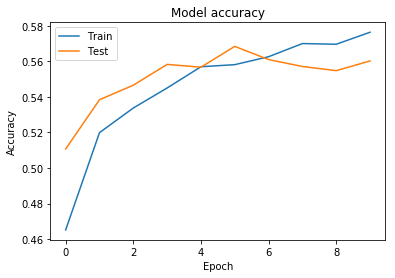

In [855]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [856]:
score, acc = model.evaluate(X_test, y_test)

8556/8556 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 286us/step


In [810]:
print("Score: {:.2f}".format(score))
print("Accuracy: {:.2f}".format(acc))

Score: 1.03
Accuracy: 0.55


It is important to note that training the model took almost 5 minutes to train (on a very small number of epochs), compared to a few seconds for the Naive Bayes model, and returned equal accuracy when predicting the rating. However, the actual predictions are not particularly important - rather, we are looking for a sentiment score that accurately reflects the opinion in the text (using the score as a crude proxy)

In [857]:
print(X_test[0,:].shape)

print(X_test[0,:])

predictions = model.predict(X_test)


    

(50,)
[  0   0   0   0   0   0   0   0   0   0   0   0   0  31  41   2  22 110
  35  45 433  43  21 264 112 237  28 203   2  20  89  31   5   1 264 144
 271  13 357 333   5 207   2   5 146  45  23  50  60 121]


#### 4.5.4 Scoring each Review in the Dataset

In [964]:
def get_lstm_sentiment_score(preds):
    return (-1*preds[:,0]) + (-0.5*preds[:,1]) + (0.5*preds[:,3]) + (1*preds[:,4])


df["lstm_sentiment_score"] = get_lstm_sentiment_score(model.predict(X))



#### 4.5.5 Evaluating Resultant Sentiment Scores

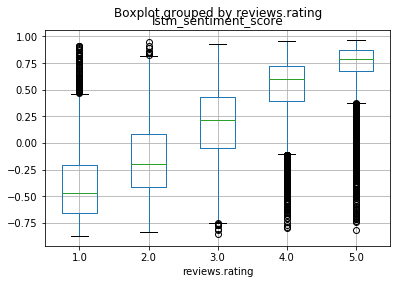

In [965]:
df.boxplot(column="lstm_sentiment_score", by="reviews.rating")

<Figure size 432x288 with 0 Axes>

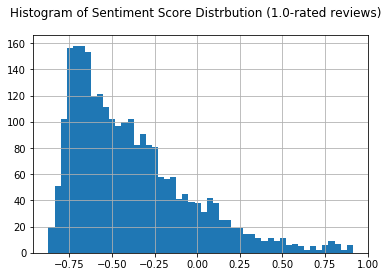

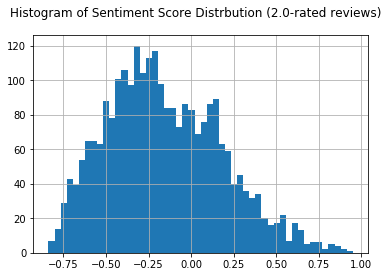

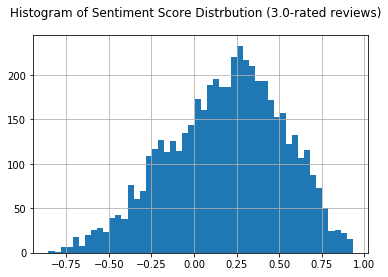

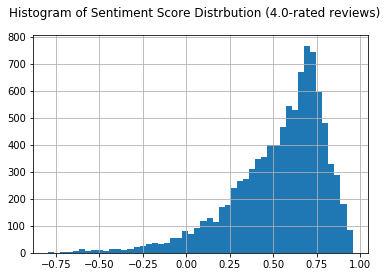

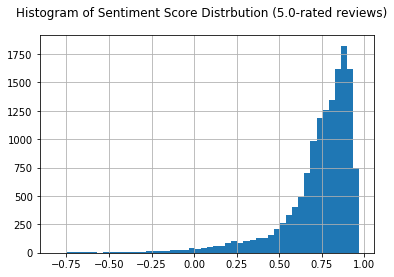

<Figure size 432x288 with 0 Axes>

In [861]:
df[df["reviews.rating"] == 1.0]["lstm_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Sentiment Score Distrbution (1.0-rated reviews)")
plt.figure()
df[df["reviews.rating"] == 2.0]["lstm_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Sentiment Score Distrbution (2.0-rated reviews)")
plt.figure()
df[df["reviews.rating"] == 3.0]["lstm_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Sentiment Score Distrbution (3.0-rated reviews)")
plt.figure()
df[df["reviews.rating"] == 4.0]["lstm_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Sentiment Score Distrbution (4.0-rated reviews)")
plt.figure()
df[df["reviews.rating"] == 5.0]["lstm_sentiment_score"].hist(bins=50)
plt.suptitle("Histogram of Sentiment Score Distrbution (5.0-rated reviews)")
plt.figure()

Here, the histograms again are clustered around points corresponding to the given review ratings - unlike the naive bayes histograms, however, there is a much greater variance. This could be because the system is better than the Naive Bayes model at understanding the underlying senitment of the text.

Interestingly, the histogram for 3.0-rated reviews, rather than being centered around 0, as would be expected, is instead centered on 0.25 (between the score for a perfectly predicted 3.0 and 4.0 review), possible indicating that, in general, when a reviewer gives a 3.0 review, it indicates a higher opinion of a place than would be expected if the rating scale were perfectly linear (that is, if the difference between each score in terms of sentiment towards the place was exactly the same at all points on the rating)

#### 4.5.6 Calculating Difference between Sentiment Score and Rating

<Figure size 432x288 with 0 Axes>

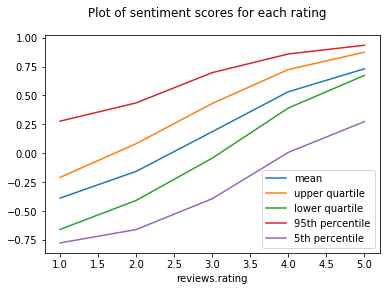

<Figure size 432x288 with 0 Axes>

In [948]:
scores_grouped = df.groupby("reviews.rating")["lstm_sentiment_score"]

pd.DataFrame({"mean" : quantiles.mean(), 
              "upper quartile": scores_grouped.quantile(0.75),
              "lower quartile": scores_grouped.quantile(0.25),
              "95th percentile": scores_grouped.quantile(0.95),
              "5th percentile": scores_grouped.quantile(0.05),
             }).plot()
plt.suptitle("Plot of sentiment scores for each rating")
plt.figure()

To calculate the difference between the sentiment score and the rating, I will use a Linear Regressor to effectively rescale the review scores into the rating range, and then calculate the absolute difference between the rescaled scores and the actual ratings

In [891]:

reg = LinearRegression().fit(df["lstm_sentiment_score"].values.reshape(-1,1), df["reviews.rating"].values)

print("Score: {:.2f}".format(reg.score(df["lstm_sentiment_score"].values.reshape(-1,1), df["reviews.rating"].values)))

Score: 0.62


In [926]:
predicted_ratings = reg.predict(df["lstm_sentiment_score"].values.reshape(-1,1))

df["lstm_score_difference"] = abs(df["reviews.rating"] - predicted_ratings)

Now we have a score representing the difference between the rating and the calculated sentiment score, we can drill down on the reviews for which the sentiment scorer seems to perform badly, to see where the model is going wrong.

In [928]:
worst_performers = (df.sort_values("lstm_score_difference", ascending=False).head(20))

In [929]:
for idx, row in worst_performers.iterrows():
    print(i)
    print(idx, "\t", 
          "Rating: {}".format(row["reviews.rating"]), "\t",
          "Sentiment Score: {:,.2f}".format(row["lstm_sentiment_score"]), "\t",
          "Difference Score: {:,.2f}".format(row["lstm_score_difference"])) 
    print(row["reviews.text"].decode("utf-8"))

reviews.rating
2558 	 Rating: 1.0 	 Sentiment Score: 0.91 	 Difference Score: 3.92
We first stumbled on this motel while taking a long ride to investigate somewhere new. We tripped over PURE GOLD!! The first time we stayed there we were in an older room and we had such a wonderful time, that we decided to go back again three months later! Our second stay absolutely amazing. We are both handicapped, and the... More
reviews.rating
5509 	 Rating: 1.0 	 Sentiment Score: 0.91 	 Difference Score: 3.91
Recently my wife Diana and I visited this hotel was wonderfully taken care of by the top-notch receptionist Scott. He even found a little treat for our dog Spencer. Also the hotel was immaculate we love all the amenities. David Allport
reviews.rating
5973 	 Rating: 1.0 	 Sentiment Score: 0.91 	 Difference Score: 3.91
I booked a room at the Hotel Deca for 3 adults and was disappointed to get a room with only one bed. But the staff at the front desk was helpful and brought us a rollaway. The staf

In [992]:
worst_performers_five_stars = (df[df["reviews.rating"] == 5.0].sort_values("lstm_score_difference", ascending=False).head(20))

In [993]:
for idx, row in worst_performers_five_stars.iterrows():
    print(i)
    print(idx, "\t", 
          "Rating: {}".format(row["reviews.rating"]), "\t",
          "Sentiment Score: {:,.2f}".format(row["lstm_sentiment_score"]), "\t",
          "Difference Score: {:,.2f}".format(row["lstm_score_difference"])) 
    print(row["reviews.text"].decode("utf-8"))

reviews.rating
12105 	 Rating: 5.0 	 Sentiment Score: -0.82 	 Difference Score: 3.27
This Hotel is HORRIBLE. When we went to bed we pulled back the sheets and there was dried blood all over the sheets. We were so disgusted. We had to fight and fight for our money back and the manager didn't even care. Do NOT stay here.
reviews.rating
911 	 Rating: 5.0 	 Sentiment Score: -0.74 	 Difference Score: 3.14
It was terrible. Would never stayhere agian. So bad i didnt even go back for my 2nd night. Worst place i have ever staid at. Very nasty needs o be closed down
reviews.rating
5377 	 Rating: 5.0 	 Sentiment Score: -0.73 	 Difference Score: 3.14
I have been a guest of this hotel between 40-50 times over the past 9 years. No one continues to return to the same place year after year if it does not meet exceed all their needs. Can I say more The food, cleanliness, price, service, management, comfort and absolutely everything is superb! I cannot recommend this place more.
reviews.rating
19497 	 R

In [994]:
worst_performers_three_stars = (df[df["reviews.rating"] == 3.0].sort_values("lstm_score_difference", ascending=False).head(20))

In [995]:
for idx, row in worst_performers_three_stars.iterrows():
    print(i)
    print(idx, "\t", 
          "Rating: {}".format(row["reviews.rating"]), "\t",
          "Sentiment Score: {:,.2f}".format(row["lstm_sentiment_score"]), "\t",
          "Difference Score: {:,.2f}".format(row["lstm_score_difference"])) 
    print(row["reviews.text"].decode("utf-8"))

reviews.rating
20145 	 Rating: 3.0 	 Sentiment Score: 0.93 	 Difference Score: 1.58
excellent hotel, great full bkfst (free) and evening appetizers w/ 2 drinks (also free) - close to lots of event venues & nightlife. clean rooms, great service. couldn't ask for more!
reviews.rating
24233 	 Rating: 3.0 	 Sentiment Score: 0.93 	 Difference Score: 1.58
Myself and my wife just returned from a week long trip to Maui. Here is an accurate review. Pros - This resort is beautiful It is practically brand new, has a great location with amazing views. We stayed in a one bedroom studio ocean view and our room was amazing. Great kitchen, spectacular views, and a comfortable bed. Cons -... More
reviews.rating
1856 	 Rating: 3.0 	 Sentiment Score: 0.93 	 Difference Score: 1.58
The guy we who worked the front desk was awesome! He gave us tips for our trip about road closures that helped us out a lot. He was super friendly and has a beautiful family. Thank you again for your help!
reviews.rating
16073 	

Looking at the reviews with the worst difference scores, we see that for the most part, the text accords with the determined sentiment value, and that the reviews seem to be simply mislabelled in the dataset.

For a few reviews where this isnt the case, the problem seems to be that the scraper for the dataset truncated the review before the reviewer managed to articulate their actual feelings about the hotel. In one particularly egregious example, review 24233, the scraper seems to truncate the reviewer's review just before she enumerates the bad points of the stay that undoubtedly led her to give a 3.0 rating, leaving only the positives in the text.

Reviews 34008 and 5377 are two of very few examples shown where the scorer seems to genuinely make an error, as the reviews are clearly aligned with the rating but are scored completely wrong. I can only speculate as to why the scorer seems to view these reviews as they are, but it seems like the reviews use particular word choices to make their points (eg. "I cannot recommend this more" for a positive review, and "secluded area" for a negative review), which could be interpreted strangely by the scorer.

Looking at the 3.0 ratings in particular, it seems like the writers of these reviews are operating on a completely different review scale to most reviewers - review ID 20145 specifically says "couldn't ask for more!", yet gives a 3.0 rating (one must wonder what a hotel would need to do to deserve a 5.0).


## 5. Conclusion

Overall, of the four approaches used in this project, only one - the SentiWordNet Average sentiment scorer - seemed completely inadequate for the task of determining the sentiment of the text. This was not unexpected, as the model underpinning the approach was extremely simple, not taking into account sentence structure, negation, or any of a number of features of the text that could have helped improve the accuracy of the sentiment analysis. That is not to say that an improved version of the model *couldn't* include aspects of these - it would be possible, for example, for a pre-processor to find words accompanied by a negation and replace with its antonym - and further work on such an approach may prove fruitful.

More unexpected, considering the simplicity of the underlying model, was the effectiveness of the Naive Bayes classifier approach (at least for english reviews). Despite taking orders of magnitude less time to train, the Naive Bayes classifier was only very slightly worse at determining the underlying sentiment than the far more complex LSTM model. This could be because the LSTM model is sub-optimal - maybe, further tuning the structure of the Neural Network and its various hyperparameters could result in a far superior model - but one would have to consider whether the added time and effort required in improving the LSTM model would be worth it.

Of the four approaches, The Google Cloud Sentiment Scorer approach fared best as accurately determining the sentiment of the review texts, and one can be certain that it is not responding to noise in the dataset (as it was not trained on the dataset at all). However, given its cost, and that the other models were not exceptionally worse, I would be reticent in recommending it as the best method to use, except in situations where price is no object. 